## <center><ins>Trabajo Práctico 2: Criticas de peliculas</ins></center>
#### <center>*Redes Neuronales*</center>
##### <center>75.06 / 95.58 Organización de Datos - FIUBA</center>
##### <center>Ing. Rodríguez - 1°C 2023</center>
---
#### <center>**Grupo 31 - "Datazo":**</center>
<center> Michael Mena - 102685</center>
<center>Pablo Brocca - 104256</center>
<center>Diego Kisinovsky - 106203</center>

---
---

## Carga de datos y librerías

In [1]:
# !pip install --upgrade tensorflow-io

In [2]:
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Manejo de modelos
from pickle import dump
from pickle import load

# Metricas
from sklearn.metrics import f1_score as f1_score_sk
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Clasificadores
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow import keras
from keras import optimizers
from keras.callbacks import EarlyStopping

import keras.backend as K # se usa para definir el f1_score

# Regularizadores
from keras import regularizers
from keras.layers import Dropout

# Optimización de hiperparámetros
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedKFold

# Manejo de modelos
from pickle import dump
from pickle import load


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
df = pd.read_csv('../input/dataset/train_preprocesado.csv', sep=',', header=0)
df.drop(['longitud'], axis=1, inplace=True)
df.head()

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,1
1,Una pequeña pequeña producción.La técnica de f...,1
2,Pensé que esta era una manera maravillosa de p...,1
3,"Básicamente, hay una familia donde un niño peq...",0
4,"El ""amor en el tiempo"" de Petter Mattei es una...",1


### Carga stopwords

In [4]:
sw = pd.read_csv('../input/dataset/my-stop-words.csv')['palabra'].to_list() # 390 palabras, 77 nuevas agregadas a mano y 308 de NLTK

print(f'Cantidad de stopwords: {len(sw)}')

Cantidad de stopwords: 390


In [5]:
# Función para eliminar las stopwords de una frase
def remove_stopwords(sentence):
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in sw]
    return ' '.join(filtered_words)

# Aplicar la eliminación de stopwords a la columna 'review_es'
df['review_es'] = df['review_es'].apply(remove_stopwords)

### Definición de funciones

In [6]:
#Funcion para evaluar los modelos
def evaluate_model_RN(model, x, y, n_splits=5, n_repeats=2):
    kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=25)
    scores = []
    for train_index, val_index in kf.split(x):
        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = pd.DataFrame(y).iloc[train_index], pd.DataFrame(y).iloc[val_index]

        model.fit(x_train, y_train)
        score = model.score(x_val, y_val)
        scores.append(score)  # Obtener el valor de score
    return np.array(scores)

In [7]:
# Esta metrica no esta implementada en keras, por lo que la definimos
def f1_score(y_true, y_pred):
    # Cálculo de la métrica F1-score
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    precision = tp / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall = tp / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

# Registramos la métrica en keras
keras.utils.get_custom_objects()['f1_score'] = f1_score

## Armado y entrenamiento

### Preparación de features:

In [8]:
target = 'sentimiento'
features = 'review_es'

### Train-Test Split:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df[target], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df[target],
                                                    shuffle=True)

# Verificamos cantidad de datos en cada set
print('# Datos Entrenamiento: {}'.format(len(X_train)))
print('# Datos Prueba: {}'.format(len(X_test)))

# Verificamos como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 40000
# Datos Prueba: 10000
% Positivos Entrenamiento: 50.000
% Positivos Prueba: 50.000


### Entrenamiento de modelo

#### Optimizacion bayesiana

In [10]:
# Convertir las críticas de texto a secuencias numéricas
tokenizer = Tokenizer(num_words=20000)  # Número máximo de palabras en el vocabulario
tokenizer.fit_on_texts(X_train)  # X_train es una lista de críticas de películas
sequences = tokenizer.texts_to_sequences(X_train)
word_index = tokenizer.word_index

# Limitar la longitud de las secuencias a un tamaño fijo (rellenando o truncando según sea necesario)
max_sequence_length = 200  # Definir la longitud máxima deseada
X_train_tokenizer = pad_sequences(sequences, maxlen=max_sequence_length)

# Convertir las etiquetas a valores numéricos (0 para negativo, 1 para positivo)
labels = np.array(y_train.replace({"negativo": 0, "positivo": 1}))

# Crear el modelo de RNN con capas GRU
model_opt = Sequential()
model_opt.add(Embedding(len(word_index) + 1, 100, input_length=max_sequence_length))  # Capa de embedding

model_opt.add(GRU(64))  # Capa GRU con 64 unidades
# model_opt.add(GRU(64, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01)))  # Regularización L2
# model_opt.add(Dropout(0.5))  # Dropout para apagar neuronas

model_opt.add(Dense(1, activation='sigmoid'))  # Capa densa con activación sigmoidal para la clasificación binaria

In [11]:
# Configurar el optimizador
optimizer = optimizers.Adadelta(learning_rate=0.1) # Alternativas: Adamax (Más lento), otros No convergen


# Compilar el modelo
model_opt.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy','f1_score'])

# Cantidad de épocas de entrenamiento
cant_epochs = 8

# Configurar el callback de Early Stopping (detiene el entrenamiento cuando no hay mejoras en la métrica de validación)
early_stopping = EarlyStopping(monitor='val_binary_accuracy', 
                               patience=4, 
                               mode='max', # mode='min' para loss (minimizar)
                               restore_best_weights=True, 
                               min_delta=0.0001)

# Entrenar el modelo
history_model_rn = model_opt.fit(X_train_tokenizer,
                                 labels, 
                                 epochs=cant_epochs, 
                                 batch_size=32, 
                                 validation_split=0.2, 
                                 verbose=1
#                                  callbacks=[early_stopping]
                                )

Epoch 1/8
1000/1000 [==============================] - 16s 10ms/step - loss: 0.6902 - binary_accuracy: 0.5552 - f1_score: 0.5155 - val_loss: 0.6855 - val_binary_accuracy: 0.5791 - val_f1_score: 0.5430
Epoch 2/8
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6577 - binary_accuracy: 0.6320 - f1_score: 0.6274 - val_loss: 0.5246 - val_binary_accuracy: 0.7320 - val_f1_score: 0.7655
Epoch 3/8
1000/1000 [==============================] - 10s 10ms/step - loss: 0.4045 - binary_accuracy: 0.8155 - f1_score: 0.8108 - val_loss: 0.3469 - val_binary_accuracy: 0.8451 - val_f1_score: 0.8445
Epoch 4/8
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3003 - binary_accuracy: 0.8736 - f1_score: 0.8699 - val_loss: 0.3092 - val_binary_accuracy: 0.8662 - val_f1_score: 0.8589
Epoch 5/8
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2575 - binary_accuracy: 0.8967 - f1_score: 0.8932 - val_loss: 0.3002 - val_binary_accuracy: 0.8734 - val_f1_score: 0.

In [12]:
# Tokenizar X_test
sequences_test = tokenizer.texts_to_sequences(X_test)
data_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

# Hacer las predicciones
y_pred_prob = model_opt.predict(data_test)
y_pred = y_pred_prob.flatten().round().astype(int) # Convertir las probabilidades a etiquetas (0 o 1)

# Calcular el f1-score en los datos de prueba
f1 = f1_score_sk(y_test, y_pred)
print("F1-score en datos de prueba:", f1)

# Calcular la exactitud en los datos de prueba
acc = accuracy_score(y_test, y_pred)
print("Exactitud en datos de prueba:", acc)

313/313 [==============================] - 2s 4ms/step
F1-score en datos de prueba: 0.8773493509009882
Exactitud en datos de prueba: 0.8734


Longitud del vocabulario completo para unigrama es: 154146

### Analisis del modelo

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      5000
           1       0.85      0.91      0.88      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



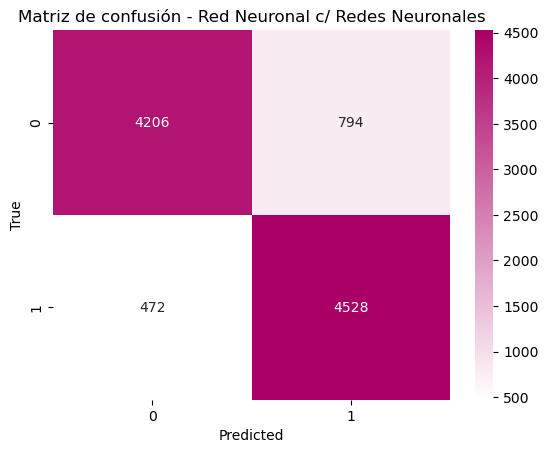

In [13]:
# Obtener la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Reporte y Matriz de Confusion
print(classification_report(y_test, y_pred))

# Definir colores
color_start = "#fff"
color_end = "#aa0065"

# Definir el mapa de colores personalizado con un degradado suave
cmap_colors = [color_start, color_end]
cmap = LinearSegmentedColormap.from_list("Custom", cmap_colors)

# Graficar la matriz de confusión con el mapa de colores personalizado
sns.heatmap(cm, cmap=cmap, annot=True, fmt='d', cbar=True)
plt.title("Matriz de confusión - Red Neuronal c/ Redes Neuronales")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
train_loss = history_model_rn.history['loss']
val_loss = history_model_rn.history['val_loss']
train_acc = history_model_rn.history['binary_accuracy']
val_acc = history_model_rn.history['val_binary_accuracy']
train_f1 = history_model_rn.history['f1_score']
val_f1 = history_model_rn.history['val_f1_score']
epochs = range(len(val_loss))

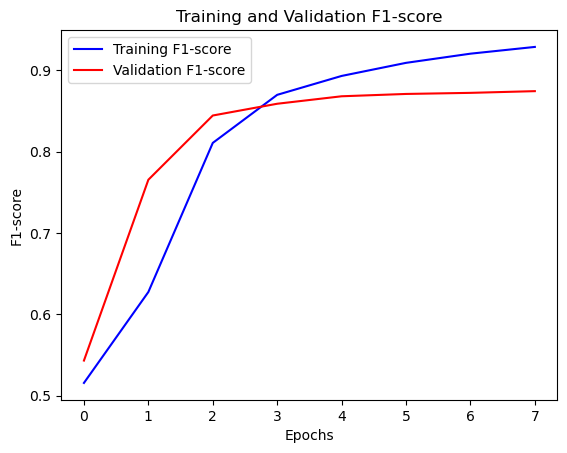

In [15]:
plt.plot(epochs, train_f1, 'b', label='Training F1-score')
plt.plot(epochs, val_f1, 'r', label='Validation F1-score')
plt.title('Training and Validation F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.show()

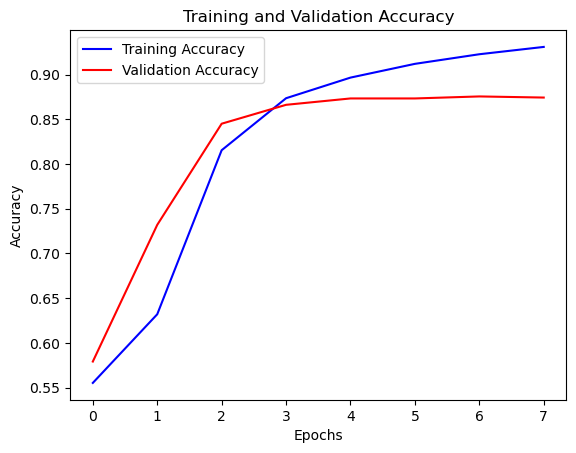

In [16]:
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

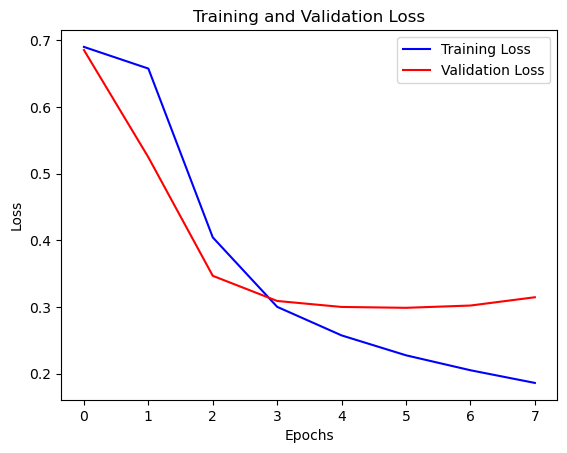

In [17]:
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

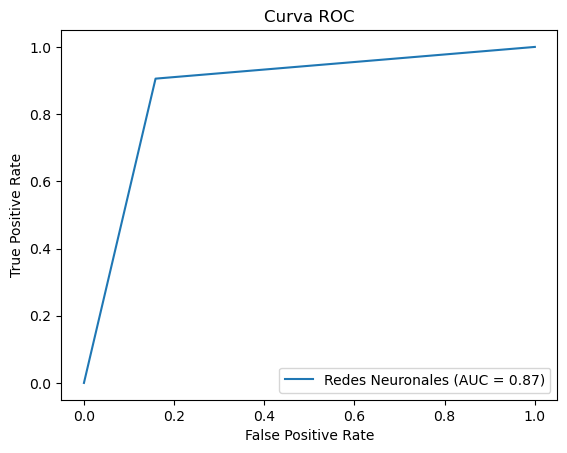

In [18]:
fpr, tpr, _ = roc_curve(y_test, y_pred) # FPR y TPR son acrónimos de "False Positive Rate" y "True Positive Rate"
roc_auc = roc_auc_score(y_test, y_pred)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Redes Neuronales').plot()
plt.title("Curva ROC")
plt.legend(loc="lower right")  # agregar leyenda en la esquina inferior derecha
plt.show()


## Aplicación del modelo al dataset de test

Lectura del dataset de test original para mantener id:

In [22]:
df_test = pd.read_csv('../input/dataset/test_preprocesado.csv', sep=',', header=0)
df_test.drop(['longitud'], axis=1, inplace=True)

In [23]:
# Aplicar la eliminación de stopwords a la columna 'review_es'
df_test['review_es'] = df_test['review_es'].apply(remove_stopwords)

In [24]:
sequences_test = tokenizer.texts_to_sequences(df_test[features])
df_test_tokenizer = pad_sequences(sequences_test, maxlen=max_sequence_length)

In [25]:
y_pred_final_prob = model_opt.predict(df_test_tokenizer)
y_pred_final = y_pred_final_prob.flatten().round().astype(int)

269/269 [==============================] - 1s 4ms/step


In [26]:
# Mapear etiquetas a valores numéricos
# label_mapping = {'negativo': 0, 'positivo': 1}
# y_pred_final_numeric = np.array([label_mapping[label] for label in y_pred_final])

# Calcular las frecuencias
counts = np.bincount(y_pred_final)
count_1 = counts[1]  # Frecuencia de positivos
count_0 = counts[0]  # Frecuencia de negativos

print("Resultado de la predicción: ")
print("Positivos: ", count_1)
print("Negativos: ", count_0)

Resultado de la predicción: 
Positivos:  5284
Negativos:  3315


In [27]:
# Mapeo de prediccion numerica a etiqueta (positivo, negativo)
y_pred_final = np.where(y_pred_final == 1, 'positivo', 'negativo')

In [28]:
pd.concat([df_test['ID'],pd.DataFrame(data=y_pred_final, columns=['sentimiento'])], axis=1).to_csv('/kaggle/working/pred_rn.csv', index=False)

## Exportación del modelo

In [29]:
model_opt.save('/kaggle/working/modelo_rn.h5')